In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np
data = pd.read_csv("upsldc.csv")
# data = data.loc['1985-01-01':]
data = data[674:]
data.head()

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,Time Stamp,Schedule(MW),Drawl(MW),OD/UD(MW),Demand(MW),Total SSGS(MW),UP Thermal Generation (MW),IPP Thermal Generation (MW),UP Hydro Generation (MW),Co-gen/CPP Generation (MW),RE/Solar Generation (MW),Frequency (Hz),Deviation Rate (Paise/Unit)
674,2019-04-24 10:17:04.681890,5798,5593,-205,14232,8639,3852,4001,416,600,31,49.92,551.03
675,2019-04-24 10:17:26.585791,5798,5593,-205,14232,8639,3852,4001,416,600,31,49.92,551.03
676,2019-04-24 10:17:38.545493,5798,5593,-205,14232,8639,3852,4001,416,600,31,49.92,551.03
677,2019-04-24 10:18:56.758521,5798,5593,-205,14232,8639,3852,4001,416,600,31,49.92,551.03
678,2019-04-24 10:19:19.920844,5798,5593,-205,14232,8639,3852,4001,416,600,31,49.92,551.03


In [2]:
# data['Time Stamp'] = pd.to_datetime(data['Time Stamp'])
# data['Time Stamp'] = data['Time Stamp'].map(lambda x: x.replace(second=0))
# data['Time Stamp'] = data['Time Stamp'].map(lambda x: x.replace(microsecond=0))
# data['Time Stamp'] = pd.to_datetime(data['Time Stamp'])

# data = data.drop_duplicates(subset='Time Stamp', keep='first')

data.set_index('Time Stamp', inplace=True)

data.index = pd.to_datetime(data.index)
# data.index = data.index.map(lambda x: x.replace(second=0))
# data.index = data.index.map(lambda x: x.replace(microsecond=0))
# data.head()

In [3]:
data = data['Demand(MW)']
data.head()

Time Stamp
2019-04-24 10:17:04.681890    14232
2019-04-24 10:17:26.585791    14232
2019-04-24 10:17:38.545493    14232
2019-04-24 10:18:56.758521    14232
2019-04-24 10:19:19.920844    14232
Name: Demand(MW), dtype: int64

In [4]:
data.columns = ['Energy Production']
data = data.astype('float64')
data.head()

Time Stamp
2019-04-24 10:17:04.681890    14232.0
2019-04-24 10:17:26.585791    14232.0
2019-04-24 10:17:38.545493    14232.0
2019-04-24 10:18:56.758521    14232.0
2019-04-24 10:19:19.920844    14232.0
Name: Demand(MW), dtype: float64

In [5]:
import numpy as np
print('Min', np.min(data))
print('Max', np.max(data))

Min 14232.0
Max 18939.0


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(data)
scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [7]:
# !pip3 install plotly
# !pip3 install cufflinks

In [8]:
#importing Pandas 
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
from  plotly.offline import plot_mpl
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

data.iplot(title="power")

In [9]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))


Min 0.0
Max 1.0


In [10]:
len(scaled)
scaled[:5]
# !pip3 install pyramid-arima


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [11]:
train_size = int(len(scaled)*.7)
test_size = int(len(scaled - train_size))
train, test = scaled[:train_size, :], scaled[train_size:, :]

print(len(train), len(test))

459 197


In [12]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[(i+look_back), 0])
        
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 12
Xtrain, Ytrain = create_dataset(train, look_back)
Xtest, Ytest = create_dataset(test, look_back)

In [14]:
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))
print(Xtrain.shape)
print(Xtest.shape)

(446, 12, 1)
(184, 12, 1)


In [15]:
batch_size = 1

# model = Sequential()
# layers = [1, 75, 100, prediction_steps]
# model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))  # add first layer
# model.add(Dropout(0.2))  # add dropout for first layer
# model.add(LSTM(layers[2], return_sequences=False))  # add second layer
# model.add(Dropout(0.2))  # add dropout for second layer
# model.add(Dense(layers[3]))  # add output layer
# model.add(Activation('linear'))  # output layer with linear activation
    
    
# model = Sequential()
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=1))
# model.add(Dense(1))
# model.compile(loss = 'mean_squared_error', optimizer='adam')
# model.fit(Xtrain, Ytrain, epochs=100, batch_size=batch_size, verbose = 2, shuffle=True)

model = Sequential()
model.add(LSTM(75, input_shape=(None, 1), return_sequences=True))  # add first layer
model.add(Dropout(0.2))  # add dropout for first layer
model.add(LSTM(100, return_sequences=False))  # add second layer
model.add(Dropout(0.2))  # add dropout for second layer
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=10, batch_size=batch_size, verbose = 2, shuffle=True)






Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 6s - loss: 0.0188
Epoch 2/10
 - 4s - loss: 0.0132
Epoch 3/10
 - 4s - loss: 0.0101
Epoch 4/10
 - 4s - loss: 0.0096
Epoch 5/10
 - 4s - loss: 0.0081
Epoch 6/10
 - 4s - loss: 0.0071
Epoch 7/10
 - 4s - loss: 0.0071
Epoch 8/10
 - 4s - loss: 0.0061
Epoch 9/10
 - 4s - loss: 0.0066
Epoch 10/10
 - 4s - loss: 0.0061


In [16]:
model.save('upsldc_model.h5')

In [17]:


import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(Xtrain, batch_size = batch_size)
# model.reset_states()
testPredict = model.predict(Xtest, batch_size = batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(-1, 1))
# testPredict = scaler.inverse_transform(np.array(testPredict).reshape(-1, 1))


ytrain = scaler.inverse_transform([Ytrain])
ytest = scaler.inverse_transform([Ytest])
    
trainScore = math.sqrt(mean_squared_error(ytrain[0], trainPredict[:,0]))    
print("train Score", trainScore)

testScore = math.sqrt(mean_squared_error(ytest[0], testPredict[:,0]))    
print("train Score", testScore)
print(ytest[0])

train Score 271.91604207663863
train Score 53.254411236689315
[18348. 18348. 18348. 18348. 18348. 18348. 18348. 18272. 18272. 18272.
 18272. 18272. 18272. 18272. 18272. 18264. 18264. 18264. 18264. 18264.
 18264. 18268. 18268. 18268. 18268. 18268. 18268. 18268. 18268. 18268.
 18222. 18222. 18222. 18222. 18222. 18222. 18235. 18235. 18235. 18235.
 18235. 18235. 18235. 18235. 18249. 18249. 18249. 18249. 18249. 18249.
 18249. 18177. 18177. 18177. 18177. 18177. 18177. 18174. 18174. 18174.
 18174. 18140. 18140. 18140. 18174. 18140. 18140. 18140. 18140. 18140.
 18098. 18098. 18098. 18098. 18098. 18098. 18098. 18098. 18103. 18103.
 18103. 18103. 18103. 18103. 18103. 18059. 18059. 18059. 18059. 18059.
 18059. 18059. 18059. 18059. 18020. 18020. 18020. 18020. 18020. 18020.
 18020. 17957. 17957. 17957. 17957. 17957. 17957. 17957. 17957. 17957.
 17957. 17913. 17913. 17913. 17913. 17913. 17901. 17832. 17832. 17832.
 17751. 17751. 17718. 17718. 17718. 17718. 17718. 17718. 17715. 17715.
 17715. 17715. 

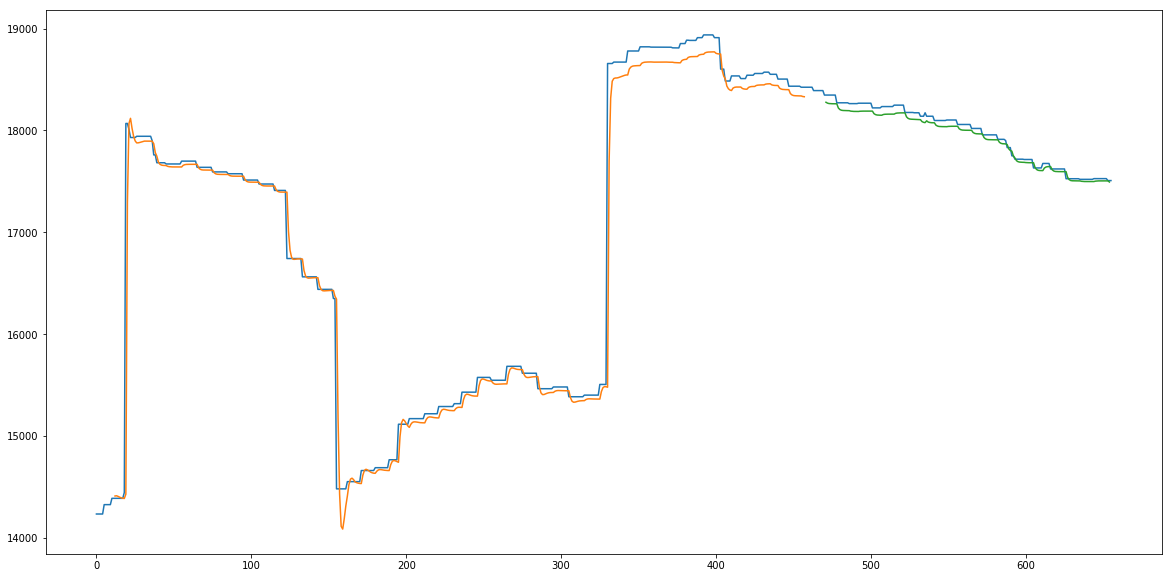

In [18]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict

plt.figure(figsize = (20, 10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()